In [3]:
from sklearn.preprocessing import MinMaxScaler

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 20, 10

In [5]:
scaler = MinMaxScaler(feature_range = (0, 1))

In [6]:
df = pd.read_csv('./data/LBMA-GOLD.csv')
df.head()


,Date,USD (PM)
0,9/12/16,1324.60
1,9/13/16,1323.65
2,9/14/16,1321.75
3,9/15/16,1310.80
4,9/16/16,1308.35


In [12]:
df['Date'] = pd.to_datetime(df.Date)
df.index = df['Date']

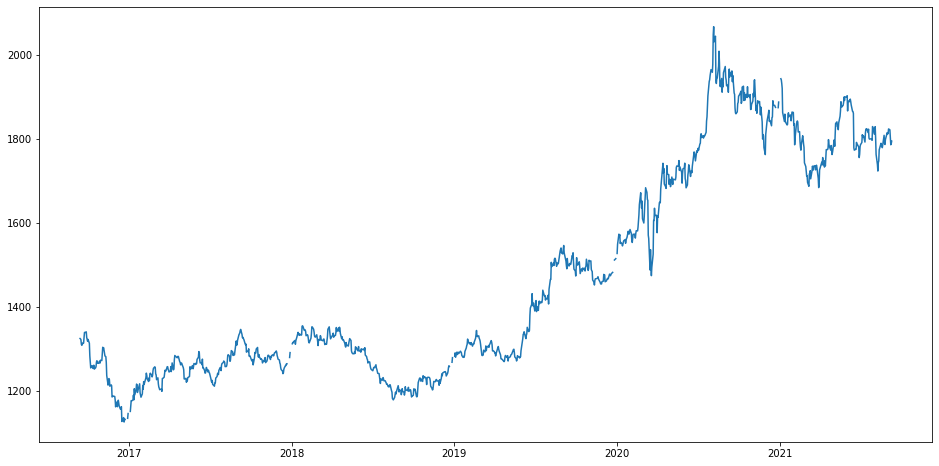

In [13]:
plt.figure(figsize=(16, 8))
plt.plot(df['USD (PM)'], label='Closing Price History')


移动平均

In [16]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df)), columns=['Date', 'Close'])
for i in range(0, len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['USD (PM)'][i]

In [22]:
train = new_data[:1013]
valid = new_data[1013:]

In [24]:
new_data.shape, train.shape, valid.shape


((1265, 2), (1013, 2), (252, 2))

In [25]:
train['Date'].min(), train['Date'].max(), valid['Date'].min(), valid['Date'].max()


(Timestamp('2016-09-12 00:00:00'),
 Timestamp('2020-09-11 00:00:00'),
 Timestamp('2020-09-14 00:00:00'),
 Timestamp('2021-09-10 00:00:00'))

In [26]:
preds = []
for i in range(0, 252):
    a = train['Close'][len(train)-252+i:].sum() + sum(preds)
    b = a / 248
    preds.append(b)

In [29]:
rms = np.sqrt(np.mean(np.power((np.array(valid['Close'])-preds),2)))
rms

nan

/var/folders/sd/6xv1d12n68jdwk95mpzzc__d5mvqc5/T/ipykernel_9526/48756350.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = 0
/var/folders/sd/6xv1d12n68jdwk95mpzzc__d5mvqc5/T/ipykernel_9526/48756350.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = preds


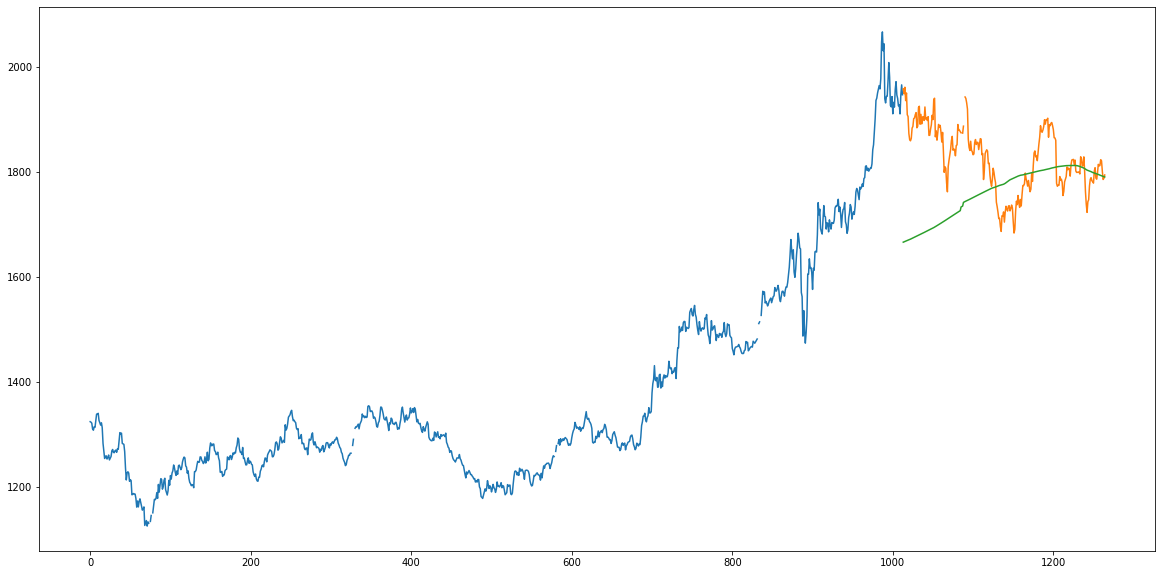

In [30]:
valid['Predictions'] = 0
valid['Predictions'] = preds
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])



k near

In [35]:
from sklearn import neighbors
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

In [56]:
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM


In [57]:
data = df.sort_index(ascending=True, axis=0)
new_data = pd.DataFrame(index=range(0, len(df)), columns = ['Date', 'Close'])
for i in range(0,len(data)):
    new_data['Date'][i] = data['Date'][i]
    new_data['Close'][i] = data['USD (PM)'][i]

In [58]:
new_data.index = new_data.Date
new_data.drop('Date', axis=1, inplace=True)
dataset = new_data.values

train = dataset[0:1013,:]
valid = dataset[1013:,:]

In [59]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(dataset)

x_train, y_train = [], []
for i in range(60,len(train)):
    x_train.append(scaled_data[i-60:i,0])
    y_train.append(scaled_data[i,0])
x_train, y_train = np.array(x_train), np.array(y_train)

x_train = np.reshape(x_train, (x_train.shape[0],x_train.shape[1],1))


In [62]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1],1)))
model.add(LSTM(units=50))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(x_train, y_train, epochs=1, batch_size=1, verbose=2)

953/953 - 13s - loss: nan - 13s/epoch - 13ms/step


In [63]:
inputs = new_data[len(new_data) - len(valid) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)

X_test = []
for i in range(60,inputs.shape[0]):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)

X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
closing_price = model.predict(X_test)
closing_price = scaler.inverse_transform(closing_price)

In [64]:
rms=np.sqrt(np.mean(np.power((valid-closing_price),2)))
rms

11.772259608962642





/Users/swang3/Documents/Projects/pythonProject/venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


11.772259608962642

/var/folders/sd/6xv1d12n68jdwk95mpzzc__d5mvqc5/T/ipykernel_9526/312860886.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid['Predictions'] = closing_price


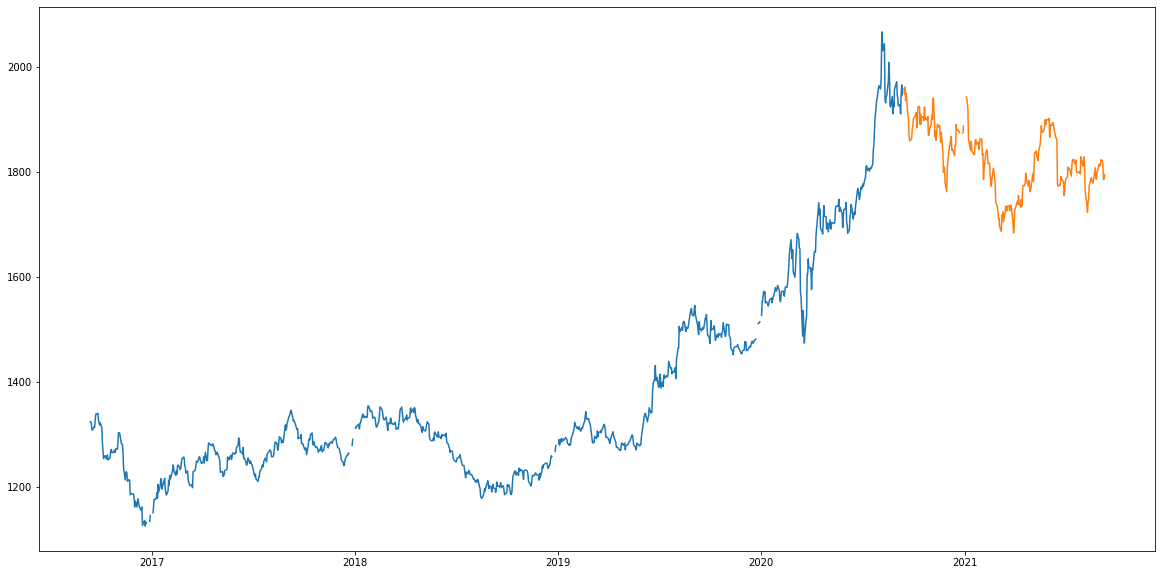

In [65]:
#for plotting
train = new_data[:1013]
valid = new_data[1013:]
valid['Predictions'] = closing_price
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])



In [67]:
closing_price


array([[nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
       [nan],
      